## For some reason, this notebook does not "validate". Therefore, before you submit it, make sure it runs if you do "Kernel" -> "Restart & Run All".

In this notebook, we explore how to detect a moving object on a stationary background.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
import imageio

In [2]:
# Here we define a helper function which we call below to make sure
# an image is an "unsigned 8 bit integer". This way, we know they
# take only a single byte per pixel and have a value from 0..255.

def ensure_dtype_uint8(arr):
    return arr.astype(np.uint8)

Here we load the first frame of a movie file saved in the Straw Lab of a fly walking.

In [3]:
fname = "data/short-movie20170810_182130.vp9-1000.mkv"
reader = imageio.get_reader(fname)
for frame in reader:
    frame0 = frame[:,:,1] # take only green channel
    break

Now, we plot the first frame (the first image) in the video. We do this once in grayscale and once in false color.

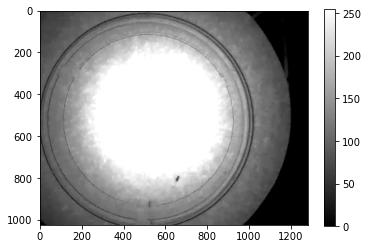

In [4]:
plt.imshow(frame0, cmap='gray')
plt.colorbar();

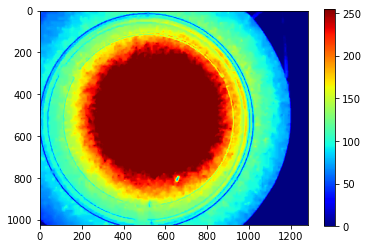

In [5]:
plt.imshow(frame0, cmap='jet')
plt.colorbar();

Note how the false color image lets you see more easily approximately what pixel intensity values are present.

Now, list make a histogram of the pixel intensity values.

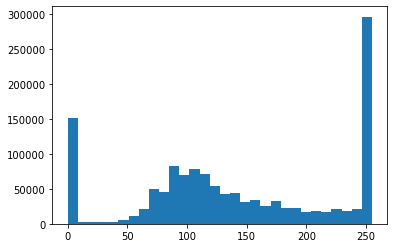

In [6]:
plt.hist(frame0.flat, bins=30);

Now we will load all the frames into a single large data structure from disk into memory.

In [7]:
# get all frames into big 3D array
(height,width) = frame0.shape
all_frames = []
reader.set_image_index(0) # return to start of file
for frame in reader:
    all_frames.append( frame[:,:,1] )
all_frames = np.array(all_frames)
print(all_frames.shape)
n_frames = len(all_frames)

(103, 1024, 1280)


Now the entire movie is stored as a large 3D array of size: number of frames x width x height.

Now, we want to find a fly in the image. The fly is moving, but the background is stationary, so we should be able to determine a single "background image". We can try to find the background image in at least two ways: with a "mean image" (also "average image"), which should average over the fly's position. And with a "median image" which should completely eliminate the fly from the backround image if the fly was absent for most of the time from each pixel.

In [8]:
mean_frame = np.mean(all_frames, axis=0)
median_frame = np.median(all_frames, axis=0)

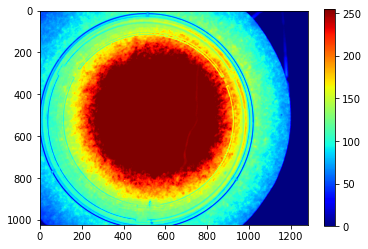

In [9]:
plt.imshow(mean_frame, cmap='jet')
plt.colorbar();

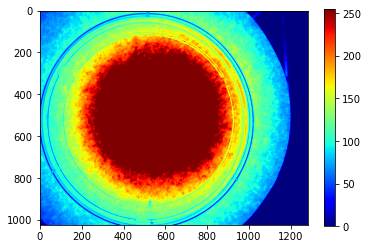

In [10]:
plt.imshow(median_frame, cmap='jet')
plt.colorbar();

Now that we have the "background", we can find the difference from background, which should emphasize anything that is moving.

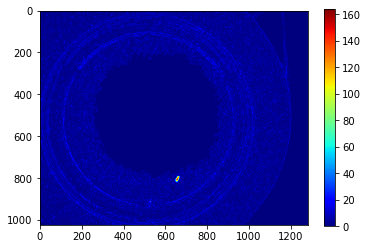

In [11]:
frame0_absdiff = abs(frame0 - median_frame)
plt.imshow(frame0_absdiff, cmap='jet')
plt.colorbar();

Now lets make a histogram of the `frame0_absdiff` image.

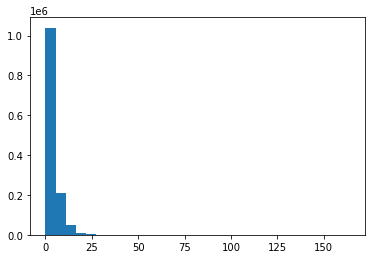

In [12]:
plt.hist(frame0_absdiff.flat, bins=30);

We want to find a threshold for this "absolute difference image" which will separate the fly from the background. From frame to frame the background changes very little - only noise in the light levels, camera sensor and caused by lossy compression to a movie format cause changes. But when the fly moves over the background, there is a large change in luminance values. This happens only in very few pixels. So few that they do not show on the histogram. However, matplotlib will automatically scale the axes, so we know there must be few pixels with values at 150 or above.

## Questions Part A

Enter a threshold below and describe why you chose this value. Put your answer in the variable `threshold`.

In [13]:
# Type your answer here and then run this and the following cell.
threshold = 100

(Here you should describe why you chose your particular threshold value.)

In [14]:
# If this runs without error, it means the answer in your previous cell was a number.
assert(threshold+0==threshold)

Now we want to "binarize" or "threshold" the image so that it is all zeros and ones (or true and false). This will let use use analyses like connected components labeling later.

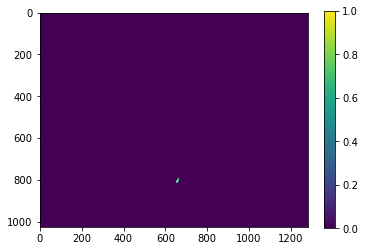

In [15]:
binarized = ensure_dtype_uint8(frame0_absdiff>threshold)
plt.imshow(binarized);
plt.colorbar();

Now we will use **connected components labeling** via the `ndimage.label()` function.

We will do more with **connected components labeling** later. For now, you can [read about connected components labeling](https://en.wikipedia.org/wiki/Connected-component_labeling).

We will use these labels to perform object detection. We will not bother to detect the fly on every single frame. Only on the frames where we have exactly one label do we say that we detected the fly. We skip the other frames, ignoring them.

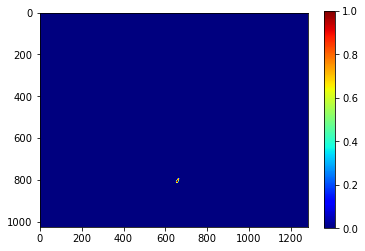

In [16]:
labels, num_labels = ndimage.label(binarized)
plt.imshow(labels, cmap='jet')
plt.colorbar();

## Questions Part B

Run the object detection algorithm for each frame and plot the result. Here, we are going to make lists `frames`, `xs`, `ys` to save the results of our object detection step.

Try re-running the above cells (from "Questions Part A") to the cell below with varying values of the `threshold` value until you get a good tracking result. You should ideally have zero warnings printed, but one or two are OK. 

In [17]:
frames = []
xs = []
ys = []
for i in range(n_frames):
    frame = all_frames[i,:,:]
    frame_absdiff = abs(frame - median_frame)
    binarized = ensure_dtype_uint8(frame_absdiff>threshold)
    labels, num_labels = ndimage.label(binarized)
    if num_labels!=1:
        print('WARNING: num_labels %d on frame %d, skipping' % (num_labels,i))
        continue
    y,x = np.mean(np.nonzero(labels==1),axis=1)
    frames.append(i)
    xs.append(x)
    ys.append(y)

Make with an image of the first frame (saved in the variable `frame0` above) in the background and then the fly trajectory overlaid on top of the image.

You can do this by first calling `plt.imshow()` and then `plt.plot()`. Your result should look like this:

![fly-tracking1.png](fly-tracking1.png)

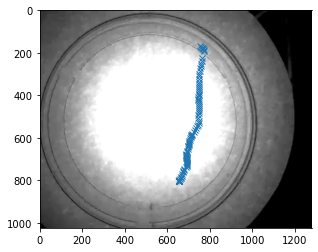

In [18]:
# Type your answer here
plt.imshow(frame0,cmap='gray');
plt.plot(xs,ys,'x');

Make a plot of the timeseries of the x and y values.

We want a plot that looks like the following. You need to fix the following code to do this.

![fly-tracking2.png](fly-tracking2.png)

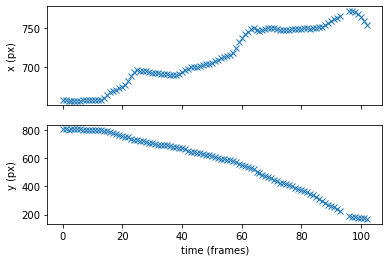

In [19]:
fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True)
axes[0].plot(frames,xs,'x')
axes[0].set_ylabel('x (px)')
axes[1].plot(frames,ys,'x')
axes[1].set_ylabel('y (px)')
axes[1].set_xlabel('time (frames)')
plt.savefig('fly-tracking2.png')

## Questions Part C

Describe: How did we get the background image? How did we compute a binary image? What did we do with the binary image?

(Answer here.)